<div style="text-align: left; font-size: 4em; font-weight: bold;">
    <br>Running Experiments in
</div>

<br>

<img src="pybamm.png" width="300" height="200">

## Background: 

In this video, we're going reivew how you can run experiments in Pybamm. If you're not familiar with running simulations in pybamm, check out the earlier lecture, *A basic intro to Pybamm* & return here when you're ready.  

----
### What is an Experiment?
Pybamm's experiment class is a useful mechanism for preparing battery model simulations under specific operating conditions.[1] Users can prepare an experiment in pybamm by passing human-readable instructions as a list of string entries to the Pybamm.Experiment() class.[2] For example, if I wanted to setup an experiment to run a 1C discharge until my battery's voltage reaches 2.8V, I could do that as shown below:  
```python
experiment = pybamm.Experiment([
    ("Discharge at 1C until 2.8V",
    "Rest for 10 minutes")
    ])
```
But you're not limited to just C-rate and time-based specifications, we can also pass instructions to run the model under load until a specific voltage condition achieved. If we wanted, we can even include a constant-voltage hold condition where we taper the current to maintain the battery voltage at some maximum or minimum operating condition. This fairly common when topping off a battery to it's full state of charge condition. [3]

Also, we can change the instructions from a C-rate basis to a specific current, and we're not limited to monotonic scenarios such as strict discharge or strict charge. Let's go through our first execution of a pybamm experiment with an example simulating these conditions.   

---

### Example Experiments:
#### Example 1: Simple Monotonic Experiment
First let's load our virtual environment and required packages

In [1]:
#Activate Virtual environment to load specific package versions
!conda activate py3122

# Import our standard packages
import matplotlib.pyplot as plt
import numpy as np
import pybamm


Next we'll load out model, specify our battery, and setup our simulation with its experiment conditions

#### Example 2: Experiment with charge/discharge and current tapering

In [2]:
# Load our model type
model = pybamm.lithium_ion.SPMe()

# Next wel'll declare our chemistry set
chemistry = pybamm.parameter_sets.Chen2020
parameter_values = pybamm.ParameterValues(values=chemistry)

# Then we'll declare our experiment
experiment = pybamm.Experiment([
    (f"Discharge at 0.3C until 3.7V",
     f"Charge at 0.3C until 4.2V",
     f"Hold at 4.2V until 50 mA",
     f"Rest for 5 minutes",
     f"Discharge at 1C until 3.5V",
     f"Hold at 3.5V until C/10"
    )
])

# And setup our simulation
sim = pybamm.Simulation(model, experiment=experiment, parameter_values=parameter_values)

# Finally we'll execute our experiment
sim.solve()

# You can use the code below to plot our results, but we'll hold off for now 
#sim.plot()

Before we plot, let's review what we just did. In the code above, we prepared an experiment for by passing a list of string tuples that read like a simple instruction guide. The pybamm developers created the experiment class in such a way that it's similar to reading a standard procedure document if you were executing a physical test in a lab environment. This helps us ensure that the test conditions we specify in our model reflect our intended test procedure(s). Now, let's go ahead and look at the plot. 

In [3]:
result = sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=5.080642891017491, step=0.05080642891017491)…

So, in our experiment plot, we see how the current changes according to our specified C-rate conditions. In the voltage vs. time plot we observe the constant voltage hold at 4.2V, where the current tapers until our threshold requirement has been achieved. Now, keep in mind that we've demonstrating the example with an SPMe model, so if you are running the same experiment in more detail (like with a DFN model), it's going to be more time-intensive due to differences in the model complexity.  

We saw above that you can simulate charge and discharge protocols, but how can we manage a test that has many repeated tests with a litany of steps to go through? We'll go through that in our next example

#### Example 3: Running an experiment with many repeated step conditions
To explore how we can setup long, repetitious experiments in pybamm, we'll base our example on the test that Cho, Lee, and Kim used to get data to fit their equivalent circuit model. [4] First they charged and discharged the cell between 4.2 and 2.5V at a 0.5 C-rate with some level of a current taper, and allowing the battery to rest for ~1 hour between conditions. Next they charged the cell to 95% SOC with a 0.5 C-rate. Then, a pulse profile was applied at every 5% SOC increment. Since the pulse duration and rest times aren't directly specified, we'll make the following asusmptions for each 5% increment: 
* Discharge pulse for 18s [5]
* rest for 1 minute
* charge pulse for 18s
* rest for 1 minute
* discharge to the next SOC condition (For Ex. start at 95%, discharge to 90% SOC)
* rest for ~1hr
* repeat discharge protocol until (and including) 5% SOC 

In [4]:
# Unfortunately, the current version of pybamm (24.1) does not allow for SOC based steps aside from the experiment termination condition. 
# So, we could either setup this in pybamm by breaking up the experiment into 19 experiments with different termination SOCs or one long experiment
# where we relate the SOC condition to the OCV of the cell at the SOC condition.  

# We're going to demonstrate first how to do it in a single experiment with voltage declared. If I knew the cell's OCV at each 5% SOC I could directly 
# Specify that, but let's assume we don't have that at the moment. We can simulate a rest condition and specify the starting SOC to get the 
# corresponding OCV, and append that to a list of OCV values corresponding to our SOC values. 

ocv_experiment = pybamm.Experiment([
     f"Rest for 5 minutes",
     f"Discharge at 2C until 2.5V"])

# Initialize an empty list to store the results
sim = pybamm.Simulation(model, experiment=ocv_experiment, parameter_values=parameter_values, )

ocv_vals = []
soc_vals = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]

# Loop through our SOC conditions to get our OCV
for val in soc_vals: 
    sim.solve(initial_soc=val)
    ocv = list(sim.solution['Voltage [V]'].entries)[0]
    ocv_vals.append(ocv)

# Check our OCV Values
ocv_vals

[4.123554674348624,
 4.096660985037031,
 4.080913321628858,
 4.042078696473576,
 3.9943026592782265,
 3.947904020549835,
 3.8895831164296535,
 3.840574377437165,
 3.7983447673027584,
 3.750870467195166,
 3.7053943205890896,
 3.6670033852799646,
 3.62904403656957,
 3.5814414860478996,
 3.5285580880548344,
 3.4851827513338427,
 3.4338873128626384,
 3.295898845512274,
 3.109434999152347]

In [5]:
# Now before we feed in all the experiment, let's first setup our duplicated step. We know each pulse after the first one at 95% SOC that we'll 
# discharge 5%, rest for an hour, then pulse, and move to the next condition. We'll use list comprehension to iterate through our ocv_list and 
# set this up

instructions = [(f"Discharge at 0.5C until {val:.2f}V", 
f"Rest for 60 minutes",
f"Discharge at 0.5C for 18 s",
f"Rest for 1 minutes",
f"Charge at 0.5C for 18 s",
f"Rest for 1 minutes",) for val in ocv_vals[1:]]

instructions

[('Discharge at 0.5C until 4.10V',
  'Rest for 60 minutes',
  'Discharge at 0.5C for 18 s',
  'Rest for 1 minutes',
  'Charge at 0.5C for 18 s',
  'Rest for 1 minutes'),
 ('Discharge at 0.5C until 4.08V',
  'Rest for 60 minutes',
  'Discharge at 0.5C for 18 s',
  'Rest for 1 minutes',
  'Charge at 0.5C for 18 s',
  'Rest for 1 minutes'),
 ('Discharge at 0.5C until 4.04V',
  'Rest for 60 minutes',
  'Discharge at 0.5C for 18 s',
  'Rest for 1 minutes',
  'Charge at 0.5C for 18 s',
  'Rest for 1 minutes'),
 ('Discharge at 0.5C until 3.99V',
  'Rest for 60 minutes',
  'Discharge at 0.5C for 18 s',
  'Rest for 1 minutes',
  'Charge at 0.5C for 18 s',
  'Rest for 1 minutes'),
 ('Discharge at 0.5C until 3.95V',
  'Rest for 60 minutes',
  'Discharge at 0.5C for 18 s',
  'Rest for 1 minutes',
  'Charge at 0.5C for 18 s',
  'Rest for 1 minutes'),
 ('Discharge at 0.5C until 3.89V',
  'Rest for 60 minutes',
  'Discharge at 0.5C for 18 s',
  'Rest for 1 minutes',
  'Charge at 0.5C for 18 s',
  'Re

In [6]:
# Now we just need to add this to our initial instructions and then we can execute. 
beginning_of_experiment =     (
     f"Charge at 0.5C until 4.2V",
     f"Hold at 4.2V until 10mA", 
     f"Rest for 60 minutes",
     f"Discharge at 0.5C until 2.5V",
     f"Rest for 60 minutes",
     f"Charge at 0.5C until {ocv_vals[0]:.2f}V",
     f"Rest for 60 minutes",
     f"Discharge at 0.5C for 18 s",
     f"Rest for 1 minutes",
     f"Charge at 0.5C for 18 s",
     f"Rest for 1 minutes",
    )

instructions.insert(0, beginning_of_experiment)

instructions

[('Charge at 0.5C until 4.2V',
  'Hold at 4.2V until 10mA',
  'Rest for 60 minutes',
  'Discharge at 0.5C until 2.5V',
  'Rest for 60 minutes',
  'Charge at 0.5C until 4.12V',
  'Rest for 60 minutes',
  'Discharge at 0.5C for 18 s',
  'Rest for 1 minutes',
  'Charge at 0.5C for 18 s',
  'Rest for 1 minutes'),
 ('Discharge at 0.5C until 4.10V',
  'Rest for 60 minutes',
  'Discharge at 0.5C for 18 s',
  'Rest for 1 minutes',
  'Charge at 0.5C for 18 s',
  'Rest for 1 minutes'),
 ('Discharge at 0.5C until 4.08V',
  'Rest for 60 minutes',
  'Discharge at 0.5C for 18 s',
  'Rest for 1 minutes',
  'Charge at 0.5C for 18 s',
  'Rest for 1 minutes'),
 ('Discharge at 0.5C until 4.04V',
  'Rest for 60 minutes',
  'Discharge at 0.5C for 18 s',
  'Rest for 1 minutes',
  'Charge at 0.5C for 18 s',
  'Rest for 1 minutes'),
 ('Discharge at 0.5C until 3.99V',
  'Rest for 60 minutes',
  'Discharge at 0.5C for 18 s',
  'Rest for 1 minutes',
  'Charge at 0.5C for 18 s',
  'Rest for 1 minutes'),
 ('Discha

In [7]:
# Now setup our simulation and run (This will take some time)
sim = pybamm.Simulation(model, experiment=instructions, parameter_values=parameter_values)

# Finally we'll execute our experiment
sim.solve()
 
sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=27.45266366434918, step=0.2745266366434918),…

#### Example 4: Experiments with temperature considerations: 

Now, in the experiments above we did not specify a unique operating temperature. You should be mindful of this while working in pybamm experiments because if the temperature is not specified in the experiment, it will default to what is specified in the parameter values for our loaded model. 

We can view what that model temperature is by accessing the parameter_values dictionary: 

In [8]:
print("Default temperature of the cell for this experiment: {}K".format(parameter_values["Initial temperature [K]"]))
print("Default ambient temperature for this experiment: {}K".format(parameter_values["Ambient temperature [K]"]))
print("Reference temperature for this model's parameter set: {}K".format(parameter_values["Reference temperature [K]"]))

Default temperature of the cell for this experiment: 298.15K
Default ambient temperature for this experiment: 298.15K
Reference temperature for this model's parameter set: 298.15K


<br>If we plot the temperature vs. experiment, you'll notice that since we did not specify a dynamic temperature profile, the model defaulted to an isothermal operating condition for the entirety of the test. 

Text(0.5, 1.0, 'Experiment temperature vs. time')

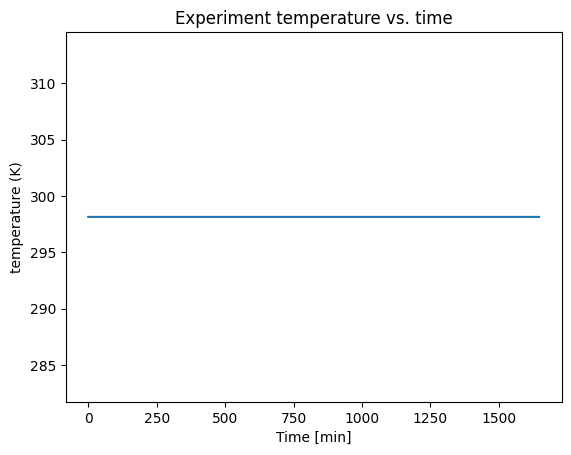

In [9]:
temp = list(sim.solution['Cell temperature [K]'].entries)[0]
time = list(sim.solution['Time [min]'].entries)
plt.plot(time, temp)
plt.xlabel('Time [min]')
plt.ylabel("temperature (K)")
plt.title("Experiment temperature vs. time")

#### How to update our initialization temperatures:
To modify our experiment so it's operating at a new temperature, we could update our parameter values called out above. For example: 
```python

# Set parameter values
parameter_values = pybamm.ParameterValues(values=chemistry)

# Update our temperature to operate at 
parameter_values["Initial temperature [K]"] = 310.15
parameter_values["Ambient temperature [K]"] = 305.15

# And setup our simulation
sim = pybamm.Simulation(model, experiment=experiment, parameter_values=parameter_values)
```

#### Example 5: Running an experiment with non-isothermal considerations

To modify our test so it is no longer isothermal, we need to update our model options, specifying which thermal conditions we wish to include. For a list of thermal model options depending on your battery cell type, check out Pybamm's docs here: <br>https://docs.pybamm.org/en/latest/source/examples/notebooks/models/thermal-models.html

It's important to recognize that thermal implications can significantly influence the practical limitations of a battery. For example, we might taper the current to maintaining temperatures within an appropriate range to prevent battery degradation. 

Text(0.5, 1.0, 'Experiment Temperature vs. Time')

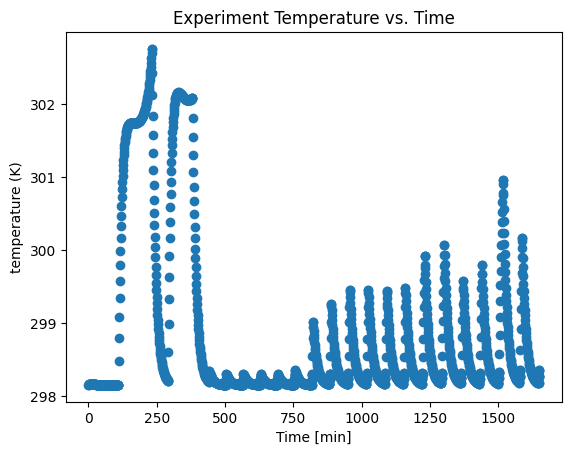

In [10]:
# Declaring a non-isothermal battery model with our pulse profile from Example 4
options = {"thermal": "lumped"}
model = pybamm.lithium_ion.SPMe(options=options)  # loading in options
sim = pybamm.Simulation(model, experiment=instructions, parameter_values=parameter_values)
sim.solve()

temp = list(sim.solution['Cell temperature [K]'].entries)[0]
time = list(sim.solution['Time [min]'].entries)

# Plot our temperature vs. time of the model
plt.plot(time, temp,'o')
plt.xlabel('Time [min]')
plt.ylabel("temperature (K)")
plt.title("Experiment Temperature vs. Time")

Text(0.5, 1.0, 'Experiment Voltage vs. Time')

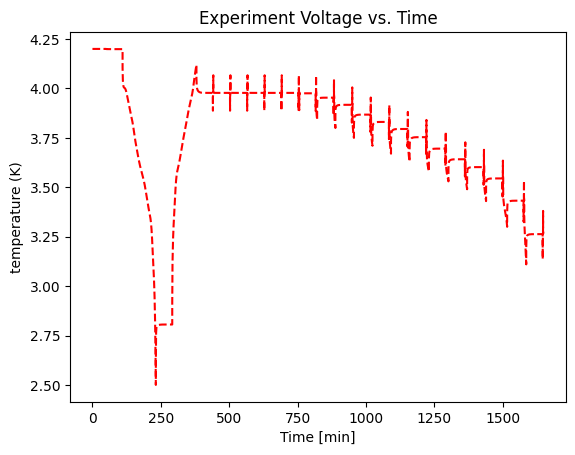

In [11]:
# Now let's compare that to the model's Voltage Vs. Time
Voltage = list(sim.solution['Voltage [V]'].entries)
time = list(sim.solution['Time [min]'].entries)

# Plot our temperature vs. time of the model
plt.plot(time, Voltage,'r--')
plt.xlabel('Time [min]')
plt.ylabel("temperature (K)")
plt.title("Experiment Voltage vs. Time")

---

### Summary:

In this lecture, we explored the pybamm.Experiments class in python. We covered 5 examples demonstrating how we can run varied experiments including simple monotonic profiles, load profiles with current tapering for voltage hold conditions, complicated profiles for dynamic tests like HPPC profiling, and how to add temperature considerations in our tests. 

We demonstrated how OCV voltages can be used to specify SOC-based changes in load profiles, noted how list comprehension can be used to quickly generate a set of instructions for dynamic operation. Finally, we identified how to change temperature profiles to support changing thermal conditions. 

In our next lecture, we're going to cover how to feed in test data into an example so we can compare a model's performance relative to experimental observations including dynamic temperature, load, and voltage responses.

---


### Training Provided By: 
Matt Jones <br>[Email](@mjones@envirolytica.com) | [LinkedIn](https://www.linkedin.com/in/jonesmatthewdavid/) <br>[Github](https://github.com/MDJonesBYU/Introduction-to-Pybamm) | [Website](www.Envirolytica.com)

---

### Citations:

1. The Pybamm Team. “Experiments.” Experiments - PyBaMM V23.3 Manual, NumFOCUS, docs.pybamm.org/en/v23.3/source/api/experiments/index.html. Accessed &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;30 Mar. 2024. 
2. The Pybamm Team. “Simulating Long Experiments#.” Simulating Long Experiments - PyBaMM V23.5 Manual, NumFOCUS, docs.pybamm.org/en/v23.5_a/source/examples/notebooks/simulating-long-experiments.html. Accessed 30 Mar. 2024. 
3. Park, Jeong-Eon. “A Control Algorithm for Tapering Charging of Li-Ion Battery in Geostationary Satellites.” A Control Algorithm for Tapering Charging of Li-Ion Battery in Geostationary Satellites, Multidisciplinary Digital Publishing Institute, 26 July 2023, www.mdpi.com/1996-1073/16/15/5636. 
4. Cho, In-Ho, et al. “Analysis of the effect of the variable charging current control method on cycle life of Li-Ion Batteries.” Energies, vol. 12, no. 15, 6 Aug. 2019, p. 3023, https://doi.org/10.3390/en12153023. 
5. Białoń, Tadeusz, et al. “HPPC test methodology using LFP Battery cell identification tests as an example.” Energies, vol. 16, no. 17, 28 Aug. 2023, p. 6239, https://doi.org/10.3390/en16176239. 


---
### Pybamm License and Copyright Details: 
[License](https://github.com/pybamm-team/PyBaMM/blob/develop/LICENSE.txt)
